In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()
prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
scale = 0.2
prev_gray = cv2.resize(prev_gray, None, fx=scale, fy=scale)

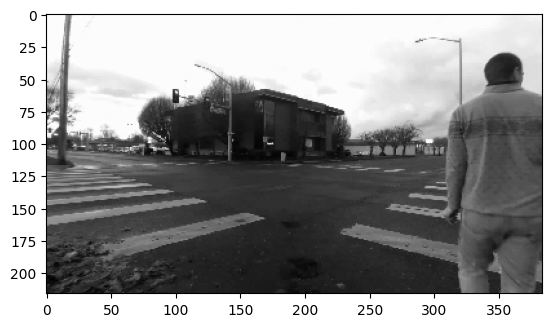

In [3]:
plt.imshow(prev_gray, cmap="gray")

In [4]:
mask = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), np.uint8)
mask[:,:,1] = 255

params = {
    "pyr_scale": 0.5,
    "levels": 1,
    "winsize": 10,
    "iterations": 3,
    "poly_n": 7,
    "poly_sigma": 1.5,
    "flags": 0
}

show_boxes = False
show_magnitudes = True
magnitude_thresh = 5

In [5]:
while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret:
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)
    
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **params)
    magnitude, angle = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
    
    if show_magnitudes and not show_boxes:
        mask[:,:,0] = angle * 180 / np.pi / 2
        mask[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        bgr_frame = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        cv2.imshow("Frame", bgr_frame)

    if show_boxes and not show_magnitudes:
        moving_regions = (magnitude > magnitude_thresh).astype(np.uint8)
        contours, _ = cv2.findContours(moving_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(curr_gray, (x, y), (x + w, y + h), 255, 2)

        cv2.imshow("Frame", curr_gray)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    prev_gray = curr_gray

video.release() 
cv2.destroyAllWindows() 